# Why hybrid method is better

### what I use:

- Dataset : AWA2
    - Class : 18 Class
    - Image per Class : 48
    - Path : C:\ProjectWork\Basic_Python\Zero_shot_Learning\Dataset\artefact1\test
        
- Dataset : AWA2
    - Class : 8 Class
    - Image per Class : 21
    - Path : C:\ProjectWork\Basic_Python\Zero_shot_Learning\Dataset\artefact1\test_sun


### Step 1: Why and How 40 to 18 logic (Sementic similarity)

...

path test AWA2 = C:\ProjectWork\Basic_Python\Zero_shot_Learning\Dataset\artefact1\test

In [1]:
# lib's
import os
import numpy as np
import pandas as pd
import cv2
import pickle
import shutil

import csv
from sklearn.cluster import KMeans
from keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.utils import img_to_array  # Updated import
from keras.models import Model

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# display all the columns of the dataframes
pd.pandas.set_option('display.max_columns', None)

### Step 2: Feture extraction by ResNet50 - (After getting 18 Classes)

In [2]:
# Variables
IMAGE_DIR = os.path.join('..', 'Dataset', 'artefact1', 'test')
image_folder_path = IMAGE_DIR

# Parameters
IMG_SIZE = (224, 224)  # Image size for the CNN
N_CLUSTERS = 2 # Number of clusters

# Load pre-trained model and remove the top layers - Load the ResNet50 model with ImageNet weights
base_model = ResNet50(weights='imagenet')
# Get the second-to-last layer (Global Average Pooling 2D)
resnet_model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

# Model path
resnet_model_file_path = os.path.join('..', 'Models', 'resnet_model_test_model.pkl')

# cluster csv
c0_file_path = os.path.join('..', 'Dataset', 'C0_features.csv')
c1_file_path = os.path.join('..', 'Dataset', 'C1_features.csv')

PCA_c0_file_path = os.path.join('..', 'Dataset', 'PCA_C0_features.csv')
PCA_c1_file_path = os.path.join('..', 'Dataset', 'PCA_C1_features.csv')

In [3]:
# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, IMG_SIZE)  # Resize image
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)  # Preprocess for VGG16
    return image

# Function to save the model
def save_model(model, file_path):
    
    with open(file_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {file_path}")

# Function to load the model
def load_model(file_path):
    
    with open(file_path, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {file_path}")
    return model

# Function to predict with the loaded model
def predict(model, data):
    return model.predict(data)

def extract_features_from_image(model):
    
    # Extract features from images
    image_paths, features, class_labels, class_number = [], [], [], []

    for class_folder in os.listdir(image_folder_path):
        class_folder_path = os.path.join(image_folder_path, class_folder)
#         print(class_folder_path, class_folder_path.split('\\')[-1].split('.')[-1].replace('_', ' '))
#         print(class_folder_path.split('\\')[-1])
        
        bird_lable = class_folder_path.split('\\')[-1].split('.')[-1].replace('_', ' ')
        bird_number = class_folder_path.split('\\')[-1].split('.')[0]
        
        #print(bird_lable, bird_number)
        
        # Ensure it's a directory
        if os.path.isdir(class_folder_path):
            for image_name in os.listdir(class_folder_path):
                image_path = os.path.join(class_folder_path, image_name)
                image_paths.append(image_path)  # Save the image path

                # Load and preprocess image
                image = load_and_preprocess_image(image_path)

                # Extract features
                feature = model.predict(image)
                features.append(feature.flatten())  # Flatten the feature array
                class_labels.append(bird_lable)
                class_number.append(bird_number)
                
    return (image_paths, features, class_labels, class_number)

def save_df(extract_features, CSV_PATH):
    features = np.array(extract_features[1])
    image_paths = np.array(extract_features[0])
    class_number = np.array(extract_features[3])
    class_labels = np.array(extract_features[2])

    df = pd.DataFrame(features)
    df['class_number'] = class_number
    df['class_labels'] = class_labels
    df['image_paths'] = image_paths
    display(df.head())
    
    df.to_csv(CSV_PATH, index=False)
    
    print(f"File saved to : {CSV_PATH}")
    
def train_kmean_model(N_CLUSTERS, features):
    
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=5)
    # clusters = kmeans.fit_predict(features) 
    # note : she using fit_predict which is wrong in this case need to use fit to train model
    kmeans.fit(features)
    
    return kmeans

In [4]:
# Print model summary
# model.summary()

# Save model
save_model(resnet_model, resnet_model_file_path)

# %%time
extract_features = extract_features_from_image(resnet_model)


Model saved to ..\Models\resnet_model_test_model.pkl
1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 424ms/step


1/1 [==============================] - 0s 205ms/step


1/1 [==============================] - 0s 246ms/step


In [5]:
# Save dataframe
CSV_PATH = os.path.join('..', 'Dataset', 'images_extract_features.csv')
save_df(extract_features, CSV_PATH)

0         1         2         3         4         5         6  \
0  0.169566  0.443888  0.038033  0.323292  0.186861  2.061228  0.318309   
1  0.250307  1.578907  0.049122  0.384802  0.420536  2.103792  0.000000   
2  0.042560  0.655144  0.040753  0.098268  0.270316  1.218815  0.107444   
3  0.098225  1.616208  0.166989  0.410855  0.069630  2.985137  0.048280   
4  0.037237  1.071350  0.037793  0.000000  0.000000  0.738029  0.000000   

          7         8         9        10        11        12        13  \
0  0.191118  0.269263  0.464712  0.043436  0.145249  0.000000  0.000000   
1  0.339524  0.106223  0.229243  0.273677  0.126856  0.006516  0.479241   
2  1.415878  0.411815  0.849117  0.015208  0.188665  0.288258  0.240850   
3  0.246293  0.544231  0.274829  0.000727  0.056307  0.038473  0.005638   
4  0.186785  0.169007  0.539413  0.303279  0.207142  0.167625  0.130550   

         14        15        16        17        18        19        20  \
0  0.373316  0.073698  0.526102  3.832308  0.178848  0.000000  0.775105   
1  0.000000  0.000000  0.181502  0.522073  0.062511  0.091988  0.045693   
2  0.021905  0.000000  0.898224  1.246319  0.067365  0.065429  0.159654   
3  0.315237  0.000000  1.540893  1.754143  0.000000  0.275165  1.336868   
4  0.016122  0.000000  1.402796  0.525345  0.001469  0.441870  0.007495   

         21        22        23        24        25        26        27  \
0  0.111226  0.000000  0.334769  0.239154  0.307704  0.026432  0.045476   
1  0.089571  0.000285  0.060890  0.134440  0.836201  0.016040  0.000000   
2  0.000000  0.040812  0.370732  0.138986  0.152055  0.010644  0.450440   
3  0.096226  0.013834  0.374551  0.218349  0.102354  0.087438  0.131290   
4  0.024472  0.006948  0.373566  0.916984  0.022961  1.507873  0.197806   

         28        29        30        31        32        33        34  \
0  0.025586  0.000000  0.415905  2.544222  0.138720  0.537058  0.360449   
1  0.037234  0.000000  0.120128  0.412669  0.431552  0.032805  0.976320   
2  0.002648  0.165317  0.348083  1.025194  0.294761  0.018899  2.745878   
3  0.133884  0.000000  0.166874  0.169619  0.585580  0.251013  0.354355   
4  0.005198  0.001691  0.049799  3.785435  0.593213  0.135594  0.474651   

         35        36        37        38        39        40        41  \
0  0.198531  0.000000  0.047336  0.059244  0.213210  0.269985  0.607112   
1  0.319117  0.298587  0.196055  0.135585  1.020941  0.220113  1.974679   
2  0.553627  0.075449  0.249076  0.422078  0.475662  0.391802  0.662778   
3  1.454042  0.199733  0.010141  0.043700  1.094114  0.481593  0.678228   
4  0.524140  0.000000  0.000000  0.000000  0.014001  1.471663  0.151641   

         42        43        44        45        46        47        48  \
0  0.000000  1.439942  0.000000  0.097629  0.552312  0.069068  0.097382   
1  0.458548  0.055461  0.194819  0.044802  0.000000  0.000000  0.000000   
2  0.218207  0.521677  0.061142  0.164880  0.074663  0.044056  0.000000   
3  0.149631  2.482382  0.252035  1.769279  0.104092  0.041399  0.000000   
4  0.051959  1.420129  0.669164  0.255924  0.000000  0.000000  0.000000   

         49        50        51        52        53        54        55  \
0  0.562251  0.160861  0.036823  0.139285  0.253400  0.098849  0.037267   
1  0.037914  0.138796  0.388995  0.063094  1.779563  0.072367  0.000000   
2  0.222386  0.265481  0.227909  0.026639  0.272028  0.007938  0.612310   
3  0.307304  0.045039  0.322631  0.016330  0.077446  0.000000  0.097818   
4  0.021855  0.338693  0.420614  0.023598  0.089860  0.000000  0.000000   

         56        57        58        59        60        61        62  \
0  0.048062  0.691981  0.081710  0.019343  1.734142  2.804297  0.519859   
1  0.074892  1.327798  0.709564  0.308441  0.251260  0.724743  0.000000   
2  0.000000  0.226041  0.286993  0.606404  0.291559  2.542021  0.368122   
3  0.008545  1.027449  0.106189  0.016610  0.214886  4.983651  1.584811   
4  0.012356  0.079644  0.56

File saved to : ..\Dataset\images_extract_features.csv


In [6]:
# apply PCA

data = pd.read_csv(CSV_PATH)
X = data.iloc[:,:2048]  
# y = data[['class_labels']] 
# X

# In order to visualize in 2D graph I will use PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_fit = pca.fit_transform(X)

df_pca = pd.DataFrame(data=pca_fit, columns=['PCA1', 'PCA2'])
df_pca['class_labels'] = data[['class_labels']] 
display(df_pca.head())

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_pca[['PCA1', 'PCA2']])

# Create a new DataFrame with scaled features
scaled_df = df_pca[['PCA1', 'PCA2']].copy()
scaled_df[['PCA1', 'PCA2']] = scaled_features
scaled_df['class_labels'] = data[['class_labels']] 

display(scaled_df.head())

PCA1      PCA2 class_labels
0 -4.319046  4.226259         bear
1 -1.343376  6.593875         bear
2 -2.891666  6.453414         bear
3 -6.801732  5.543529         bear
4  4.653983  4.937040         bear

PCA1      PCA2 class_labels
0  0.253617  0.551788         bear
1  0.323082  0.609280         bear
2  0.286938  0.605869         bear
3  0.195660  0.583775         bear
4  0.463087  0.569048         bear

#### main root -- 8

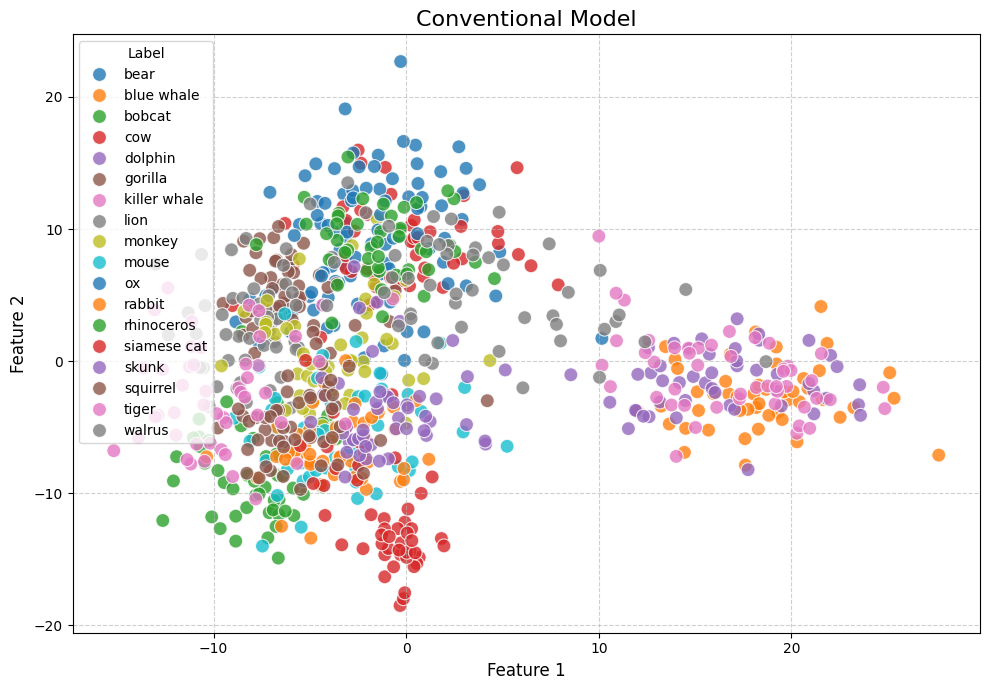

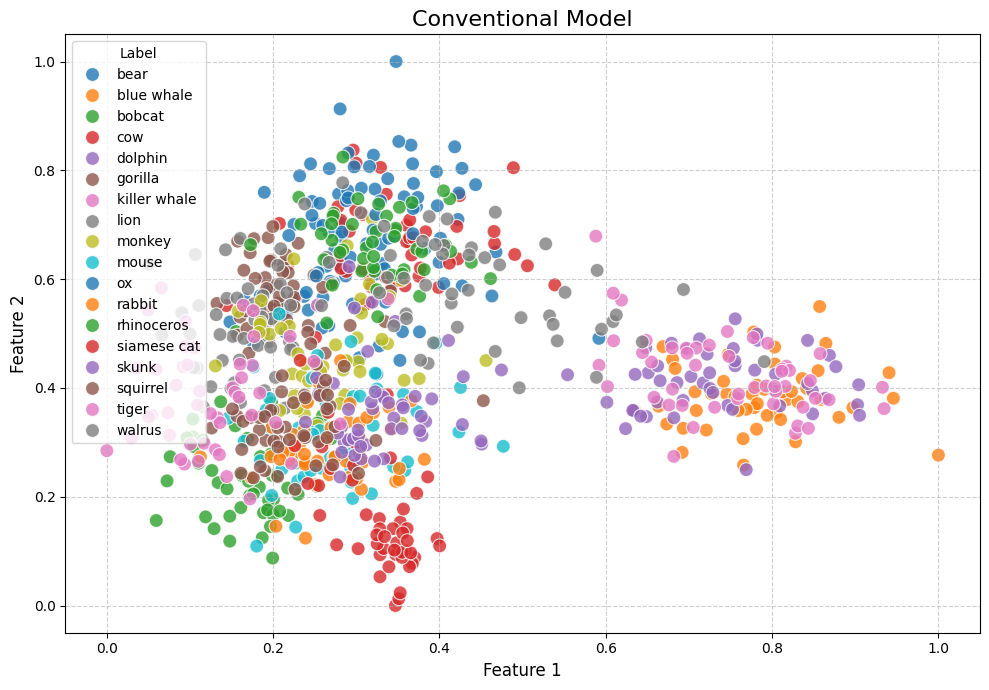

In [7]:
def plot_pca(dataframe, x_lable, y_lable, class_hue_lable, palette='tab20', graph_color=None, multi_cluster=True,
             graph_title='2D Scatter Plot', graph_xlabel='X', graph_ylabel='Y'):

    plt.figure(figsize=(10, 7))
    if graph_color == None:
        if multi_cluster:
            sns.scatterplot(data=dataframe, x=x_lable, y=y_lable, hue=class_hue_lable, 
                            palette=palette, s=100, alpha=0.8)
        else:
            sns.scatterplot(data=dataframe, x=x_lable, y=y_lable, hue=class_hue_lable, 
                            palette=palette, s=100, alpha=0.8)
            # Set x and y axis limits from 0 to 1
            plt.xlim(-0.1, 1.1)
            plt.ylim(-0.1, 1.1)
    else:
        sns.scatterplot(data=dataframe, x=x_lable, y=y_lable, color=graph_color, 
                        palette=palette, s=100, alpha=0.8)
        # Set x and y axis limits from 0 to 1
        plt.xlim(-0.1, 1.1)
        plt.ylim(-0.1, 1.1)

    plt.title(graph_title, fontsize=16)
    plt.xlabel(graph_xlabel, fontsize=12)
    plt.ylabel(graph_ylabel, fontsize=12)
    plt.legend(title='Label', loc='upper left') # bbox_to_anchor=(1.05, 1), : Put the legend outside the plot
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot PCA
plot_pca(df_pca, 'PCA1', 'PCA2', 'class_labels', palette='tab10', 
         graph_title='Conventional Model', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_pca(scaled_df, 'PCA1', 'PCA2', 'class_labels', palette='tab10', 
         graph_title='Conventional Model', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')


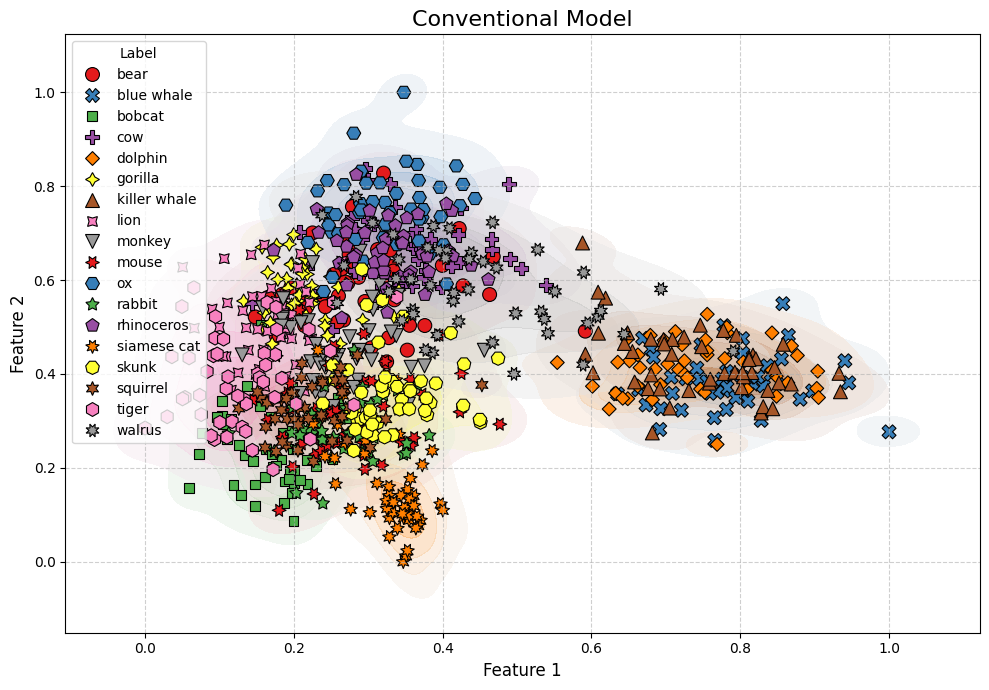

In [8]:
def plot_2d_scatter_with_hue_background(df, x_col, y_col, class_label_col, 
                                        graph_title='2D Scatter Plot', graph_xlabel='X', graph_ylabel='Y'):
    """
    Plots a 2D scatter plot with a soft KDE background for each class label.

    :param df: Pandas DataFrame
    :param x_col: Column name for X-axis
    :param y_col: Column name for Y-axis
    :param class_label_col: Column name containing class labels (used for hue)
    """
    plt.figure(figsize=(10, 7))
    
    unique_labels = df[class_label_col].unique()
    colors = sns.color_palette("Set1", len(unique_labels))

    # Plot KDE background for each class
    for label, color in zip(unique_labels, colors):
        subset = df[df[class_label_col] == label]
        if len(subset) > 1:  # KDE needs more than one point
            sns.kdeplot(x=subset[x_col], y=subset[y_col], cmap=sns.light_palette(color, as_cmap=True),
                        fill=True, alpha=0.4, levels=5, thresh=0.05)

    # Scatter plot with hue
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=class_label_col, style=class_label_col,
                    palette="Set1", s=100, edgecolor='black')

    plt.title(graph_title, fontsize=16)
    plt.xlabel(graph_xlabel, fontsize=12)
    plt.ylabel(graph_ylabel, fontsize=12)
    plt.legend(title='Label', loc='upper left') # bbox_to_anchor=(1.05, 1), : Put the legend outside the plot
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


# Call the function
plot_2d_scatter_with_hue_background(scaled_df, 'PCA1', 'PCA2', 'class_labels', 
                                    graph_title='Conventional Model', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')


In [9]:
# Convert features to numpy array
features = scaled_df.iloc[:,:2]

# Train Kmean model
clusters = train_kmean_model(N_CLUSTERS, features)
print(clusters)

# Save the model
file_path = os.path.join('..', 'Models', 'kmean_model.pkl')
save_model(clusters, file_path)

# Load the model
clusters = load_model(file_path)

# Predict with the loaded model
y_pred_clusters = predict(clusters, features)
print(y_pred_clusters)

KMeans(n_clusters=2, random_state=5)
Model saved to ..\Models\kmean_model.pkl
Model loaded from ..\Models\kmean_model.pkl
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [10]:
scaled_df['y_pred_clusters'] = y_pred_clusters
scaled_df.head()

PCA1      PCA2 class_labels  y_pred_clusters
0  0.253617  0.551788         bear                1
1  0.323082  0.609280         bear                1
2  0.286938  0.605869         bear                1
3  0.195660  0.583775         bear                1
4  0.463087  0.569048         bear                1

In [11]:
# plot_pca(scaled_df, 'PCA1', 'PCA2', 'y_pred_clusters', palette='tab10')

In [12]:
# Group by Class and Cluster and count the occurrences
grouped = scaled_df.groupby(['class_labels', 'y_pred_clusters']).size().unstack(fill_value=0)

# Add a new column to determine the predominant cluster
grouped['finalCluster'] = (grouped[0] < grouped[1]).astype(int)

grouped

y_pred_clusters   0   1  finalCluster
class_labels                         
bear              1  47             1
blue whale       48   0             0
bobcat            0  48             1
cow               1  47             1
dolphin          48   0             0
gorilla           0  48             1
killer whale     48   0             0
lion              0  48             1
monkey            0  48             1
mouse             0  48             1
ox                0  48             1
rabbit            0  48             1
rhinoceros        0  47             1
siamese cat       0  48             1
skunk             0  48             1
squirrel          0  48             1
tiger             0  48             1
walrus           13  35             1

In [13]:
# Save the results to a new CSV file
output_path = os.path.join('..', 'Dataset', 'grouped.csv')  # Specify your output file path here
grouped.to_csv(output_path)
grouped = pd.read_csv(output_path)
# print(grouped.columns, '\n')

# Filter the classes based on the predominant cluster
# cluster_0_classes = grouped[grouped['finalCluster'] == 0]['class_labels'].tolist()
# cluster_1_classes = grouped[grouped['finalCluster'] == 1]['class_labels'].tolist()
cluster_0_classes = grouped.loc[grouped['finalCluster'] == 0, 'class_labels'].tolist()
cluster_1_classes = grouped.loc[grouped['finalCluster'] == 1, 'class_labels'].tolist()

# Print the lists
print("Classes in Cluster 0: ", cluster_0_classes, "\n")
print("Classes in Cluster 1: ", cluster_1_classes)

Classes in Cluster 0:  ['blue whale', 'dolphin', 'killer whale'] 

Classes in Cluster 1:  ['bear', 'bobcat', 'cow', 'gorilla', 'lion', 'monkey', 'mouse', 'ox', 'rabbit', 'rhinoceros', 'siamese cat', 'skunk', 'squirrel', 'tiger', 'walrus']


In [14]:
scaled_df['cluster'] = scaled_df['class_labels'].apply(lambda x: 0 if x in cluster_0_classes else 1)
scaled_df

PCA1      PCA2 class_labels  y_pred_clusters  cluster
0    0.253617  0.551788         bear                1        1
1    0.323082  0.609280         bear                1        1
2    0.286938  0.605869         bear                1        1
3    0.195660  0.583775         bear                1        1
4    0.463087  0.569048         bear                1        1
..        ...       ...          ...              ...      ...
858  0.409166  0.710531       walrus                1        1
859  0.267354  0.630821       walrus                1        1
860  0.435545  0.644406       walrus                1        1
861  0.643911  0.484640       walrus                0        1
862  0.258262  0.551203       walrus                1        1

[863 rows x 5 columns]

#### 4-4

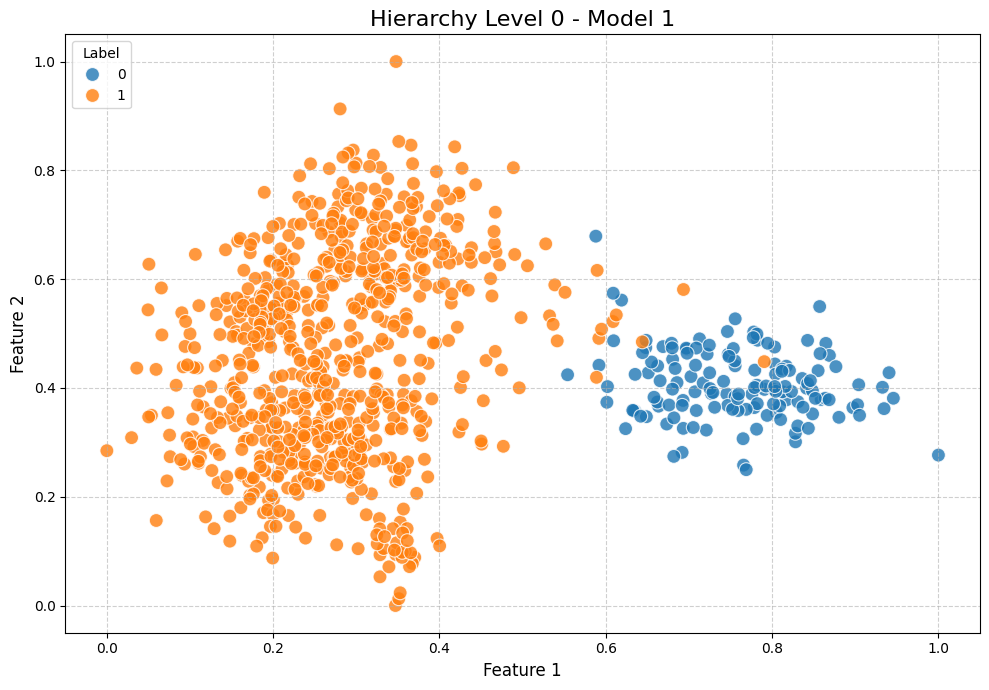

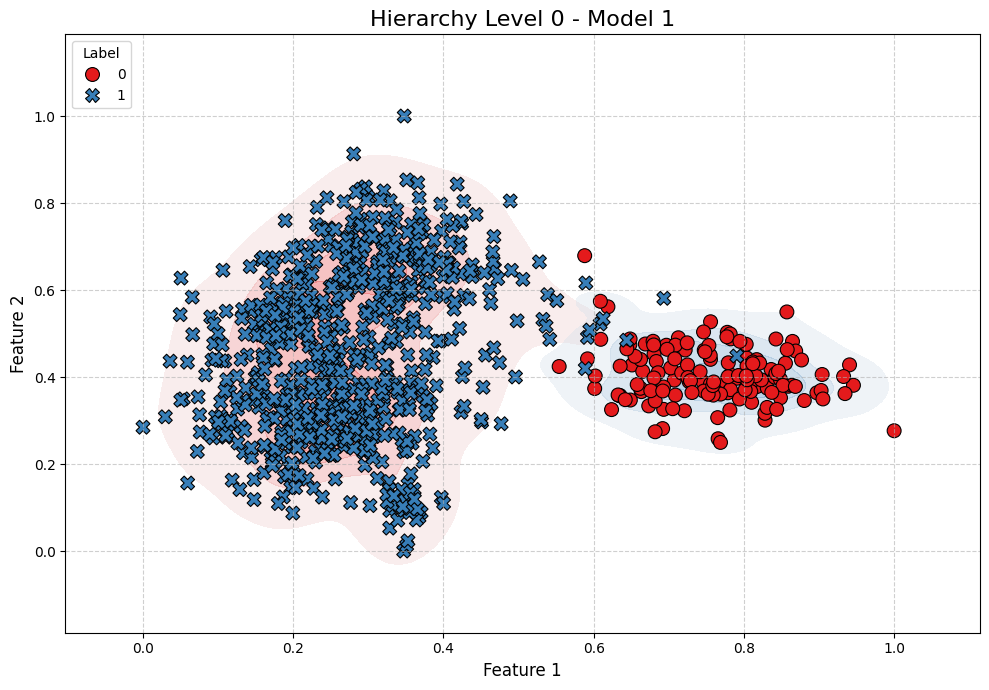

In [15]:
plot_pca(scaled_df, 'PCA1', 'PCA2', 'cluster', palette='tab10',
         graph_title='Hierarchy Level 0 - Model 1', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_2d_scatter_with_hue_background(scaled_df, 'PCA1', 'PCA2', 'cluster', 
                                    graph_title='Hierarchy Level 0 - Model 1', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')

In [16]:

data = pd.read_csv(CSV_PATH)
# X = data.iloc[:,:2048]  
# y = data[['class_labels']] 

data_c0 = data[data['class_labels'].isin(cluster_0_classes)]
data_c1 = data[data['class_labels'].isin(cluster_1_classes)]

data_c0.to_csv(c0_file_path, index=False)
data_c1.to_csv(c1_file_path, index=False)

data_c0 = pd.read_csv(c0_file_path)
data_c1 = pd.read_csv(c1_file_path)

print(f"{data.shape} \n{data_c0.shape} \n{data_c1.shape}")


(863, 2051) 
(144, 2051) 
(719, 2051)


In [17]:
# data = pd.read_csv(CSV_PATH)
# X = data.iloc[:,:2048]  
# y = data[['class_labels']] 

data_PCA_c0 = scaled_df[scaled_df['class_labels'].isin(cluster_0_classes)]
data_PCA_c1 = scaled_df[scaled_df['class_labels'].isin(cluster_1_classes)]

data_PCA_c0.to_csv(PCA_c0_file_path, index=False)
data_PCA_c1.to_csv(PCA_c1_file_path, index=False)

data_PCA_c0 = pd.read_csv(PCA_c0_file_path)
data_PCA_c1 = pd.read_csv(PCA_c1_file_path)

print(f"{scaled_df.shape} \n{data_PCA_c0.shape} \n{data_PCA_c1.shape}")


(863, 5) 
(144, 5) 
(719, 5)


In [18]:
data_PCA_c0.head(2)

PCA1      PCA2 class_labels  y_pred_clusters  cluster
0  0.94581  0.381036   blue whale                0        0
1  1.00000  0.276532   blue whale                0        0

In [19]:
data_PCA_c1.head(2)

PCA1      PCA2 class_labels  y_pred_clusters  cluster
0  0.253617  0.551788         bear                1        1
1  0.323082  0.609280         bear                1        1

In [20]:
# plot_pca(data_PCA_c0, 'PCA1', 'PCA2', 'cluster', graph_color='blue', graph_title='Level 1 - Left side')

# plot_pca(data_PCA_c1, 'PCA1', 'PCA2', 'cluster', graph_color='orange', graph_title='Level 1 - Right side')

# plot_2d_scatter_with_hue_background(data_PCA_c0, 'PCA1', 'PCA2', 'cluster', graph_title='Level 1 - Left side')

# plot_2d_scatter_with_hue_background(data_PCA_c1, 'PCA1', 'PCA2', 'cluster', graph_title='Level 1 - Right side')

In [21]:
# data_PCA_c0, data_PCA_c1

# Convert features to numpy array
features = data_PCA_c0.iloc[:,:2]

# Train Kmean model
clusters = train_kmean_model(N_CLUSTERS, features)
print(clusters)

# Save the model
file_path = os.path.join('..', 'Models', 'kmean_model_left_PCA_c0.pkl')
save_model(clusters, file_path)

# Load the model
clusters = load_model(file_path)

# Predict with the loaded model
y_pred_clusters = predict(clusters, features)
print(y_pred_clusters)

KMeans(n_clusters=2, random_state=5)
Model saved to ..\Models\kmean_model_left_PCA_c0.pkl
Model loaded from ..\Models\kmean_model_left_PCA_c0.pkl
[1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1
 1 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 0
 0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1
 0 1 1 1 0 1 0 1 0 0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1]


In [22]:
data_PCA_c0['y_pred_clusters'] = y_pred_clusters
data_PCA_c0.head()

PCA1      PCA2 class_labels  y_pred_clusters  cluster
0  0.945810  0.381036   blue whale                1        0
1  1.000000  0.276532   blue whale                1        0
2  0.836233  0.417344   blue whale                1        0
3  0.781313  0.324194   blue whale                1        0
4  0.775725  0.388813   blue whale                1        0

In [23]:
# plot_pca(data_PCA_c0, 'PCA1', 'PCA2', 'y_pred_clusters', multi_cluster=False, 
#          palette='tab10', graph_title='Hierarchy Level 1 - Model 2')

# plot_2d_scatter_with_hue_background(data_PCA_c0, 'PCA1', 'PCA2', 'y_pred_clusters', 
#                                     graph_title='Hierarchy Level 1 - Model 2')

# # plot_pca(data_PCA_c1, 'PCA1', 'PCA2', 'y_pred_clusters', multi_cluster=False, 
# #          palette='tab10', graph_title='Level 2 - Right side')

In [24]:
# Group by Class and Cluster and count the occurrences
grouped = data_PCA_c0.groupby(['class_labels', 'y_pred_clusters']).size().unstack(fill_value=0)

# Add a new column to determine the predominant cluster
grouped['finalCluster'] = (grouped[0] < grouped[1]).astype(int)

grouped

y_pred_clusters   0   1  finalCluster
class_labels                         
blue whale       15  33             1
dolphin          29  19             0
killer whale     24  24             0

In [25]:
# Save the results to a new CSV file
output_path = os.path.join('..', 'Dataset', 'Level 2_Left side_grouped.csv')  # Specify your output file path here
grouped.to_csv(output_path)
grouped = pd.read_csv(output_path)
# print(grouped.columns, '\n')

# Filter the classes based on the predominant cluster
cluster_0_classes = grouped.loc[grouped['finalCluster'] == 0, 'class_labels'].tolist()
cluster_1_classes = grouped.loc[grouped['finalCluster'] == 1, 'class_labels'].tolist()

# Print the lists
print("Classes in Cluster 0: ", cluster_0_classes, "\n")
print("Classes in Cluster 1: ", cluster_1_classes)

Classes in Cluster 0:  ['dolphin', 'killer whale'] 

Classes in Cluster 1:  ['blue whale']


In [26]:
data_PCA_c0['cluster'] = data_PCA_c0['class_labels'].apply(lambda x: 0 if x in cluster_0_classes else 1)
data_PCA_c0

PCA1      PCA2  class_labels  y_pred_clusters  cluster
0    0.945810  0.381036    blue whale                1        1
1    1.000000  0.276532    blue whale                1        1
2    0.836233  0.417344    blue whale                1        1
3    0.781313  0.324194    blue whale                1        1
4    0.775725  0.388813    blue whale                1        1
..        ...       ...           ...              ...      ...
139  0.837128  0.364648  killer whale                1        0
140  0.843613  0.325729  killer whale                1        0
141  0.591814  0.441779  killer whale                0        0
142  0.648453  0.487503  killer whale                0        0
143  0.759696  0.388689  killer whale                1        0

[144 rows x 5 columns]

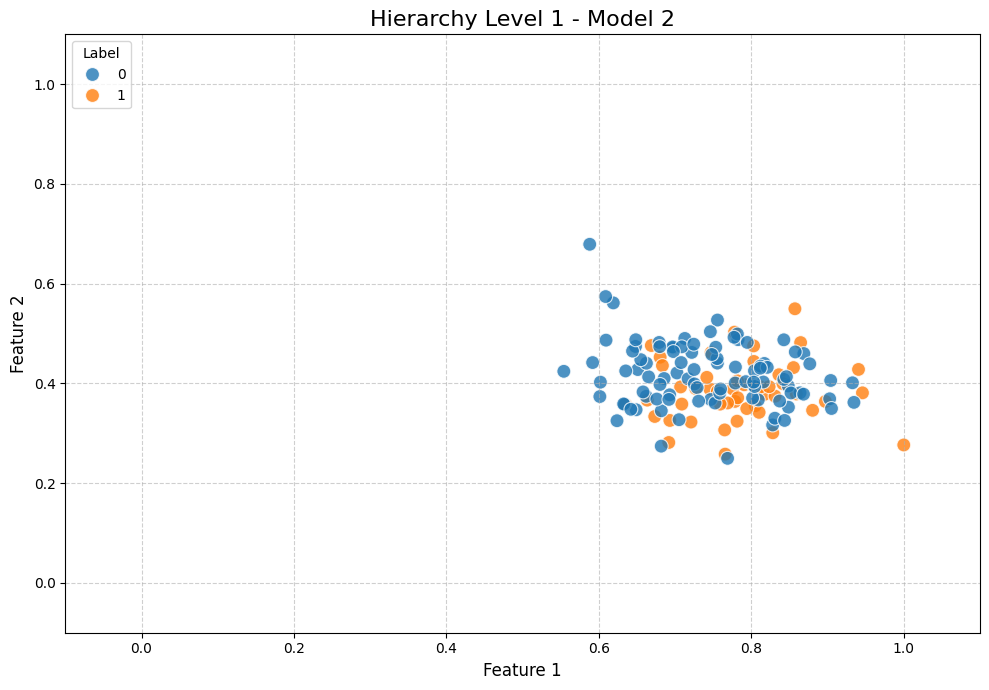

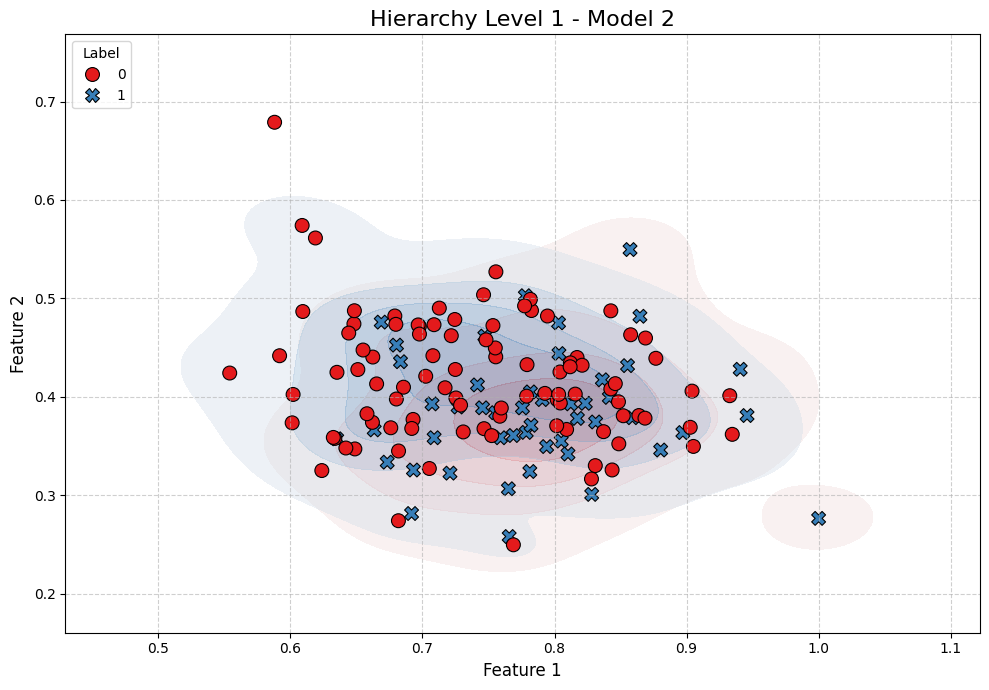

In [27]:
plot_pca(data_PCA_c0, 'PCA1', 'PCA2', 'cluster', multi_cluster=False, palette='tab10', 
         graph_title='Hierarchy Level 1 - Model 2', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_2d_scatter_with_hue_background(data_PCA_c0, 'PCA1', 'PCA2', 'cluster', 
                                    graph_title='Hierarchy Level 1 - Model 2', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')

In [28]:
data_PCA_c0

PCA1      PCA2  class_labels  y_pred_clusters  cluster
0    0.945810  0.381036    blue whale                1        1
1    1.000000  0.276532    blue whale                1        1
2    0.836233  0.417344    blue whale                1        1
3    0.781313  0.324194    blue whale                1        1
4    0.775725  0.388813    blue whale                1        1
..        ...       ...           ...              ...      ...
139  0.837128  0.364648  killer whale                1        0
140  0.843613  0.325729  killer whale                1        0
141  0.591814  0.441779  killer whale                0        0
142  0.648453  0.487503  killer whale                0        0
143  0.759696  0.388689  killer whale                1        0

[144 rows x 5 columns]

In [29]:
cluster_0_classes, cluster_1_classes

(['dolphin', 'killer whale'], ['blue whale'])

In [30]:
Left_side_PCA_c0_file_path = os.path.join('..', 'Dataset', 'Left_side_PCA_C0_features.csv')
Left_side_PCA_c1_file_path = os.path.join('..', 'Dataset', 'Left_side_PCA_C1_features.csv')

data_Left_side_PCA_c0 = data_PCA_c0[data_PCA_c0['class_labels'].isin(cluster_0_classes)]
data_Left_side_PCA_c1 = data_PCA_c0[data_PCA_c0['class_labels'].isin(cluster_1_classes)]

data_Left_side_PCA_c0.to_csv(Left_side_PCA_c0_file_path, index=False)
data_Left_side_PCA_c1.to_csv(Left_side_PCA_c1_file_path, index=False)

data_Left_side_PCA_c0 = pd.read_csv(Left_side_PCA_c0_file_path)
data_Left_side_PCA_c1 = pd.read_csv(Left_side_PCA_c1_file_path)

print(f"{data_PCA_c0.shape} \n{data_Left_side_PCA_c0.shape} \n{data_Left_side_PCA_c1.shape}")


(144, 5) 
(96, 5) 
(48, 5)


#### 2-2

In [31]:
# data_Left_side_PCA_c0, data_Left_side_PCA_c1

# Convert features to numpy array
features = data_Left_side_PCA_c0.iloc[:,:2]

# Train Kmean model
clusters = train_kmean_model(N_CLUSTERS, features)
print(clusters)

# Save the model
file_path = os.path.join('..', 'Models', 'kmean_model.pkl')
save_model(clusters, file_path)

# Load the model
clusters = load_model(file_path)

# Predict with the loaded model
y_pred_clusters = predict(clusters, features)
print(y_pred_clusters)

KMeans(n_clusters=2, random_state=5)
Model saved to ..\Models\kmean_model.pkl
Model loaded from ..\Models\kmean_model.pkl
[0 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1 0 1 1 1 0
 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0
 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1]


In [32]:
data_Left_side_PCA_c0['y_pred_clusters'] = y_pred_clusters
data_Left_side_PCA_c0.head()

PCA1      PCA2 class_labels  y_pred_clusters  cluster
0  0.554041  0.424202      dolphin                0        0
1  0.651062  0.427732      dolphin                0        0
2  0.904148  0.405835      dolphin                1        0
3  0.662119  0.374103      dolphin                0        0
4  0.702462  0.420946      dolphin                0        0

In [33]:
# Group by Class and Cluster and count the occurrences
grouped = data_Left_side_PCA_c0.groupby(['class_labels', 'y_pred_clusters']).size().unstack(fill_value=0)

# Add a new column to determine the predominant cluster
grouped['finalCluster'] = (grouped[0] < grouped[1]).astype(int)

grouped

y_pred_clusters   0   1  finalCluster
class_labels                         
dolphin          27  21             0
killer whale     24  24             0

In [34]:
# Save the results to a new CSV file
output_path = os.path.join('..', 'Dataset', 'Left_side_PCA_c0_grouped.csv')  # Specify your output file path here
grouped.to_csv(output_path)
grouped = pd.read_csv(output_path)
# print(grouped.columns, '\n')

# Filter the classes based on the predominant cluster
cluster_0_classes = grouped.loc[grouped['finalCluster'] == 0, 'class_labels'].tolist()
cluster_1_classes = grouped.loc[grouped['finalCluster'] == 1, 'class_labels'].tolist()

# Print the lists
print("Classes in Cluster 0: ", cluster_0_classes, "\n")
print("Classes in Cluster 1: ", cluster_1_classes)

Classes in Cluster 0:  ['dolphin', 'killer whale'] 

Classes in Cluster 1:  []


In [35]:
data_Left_side_PCA_c0['cluster'] = data_Left_side_PCA_c0['class_labels'].apply(lambda x: 0 if x in cluster_0_classes else 1)
data_Left_side_PCA_c0

PCA1      PCA2  class_labels  y_pred_clusters  cluster
0   0.554041  0.424202       dolphin                0        0
1   0.651062  0.427732       dolphin                0        0
2   0.904148  0.405835       dolphin                1        0
3   0.662119  0.374103       dolphin                0        0
4   0.702462  0.420946       dolphin                0        0
..       ...       ...           ...              ...      ...
91  0.837128  0.364648  killer whale                1        0
92  0.843613  0.325729  killer whale                1        0
93  0.591814  0.441779  killer whale                0        0
94  0.648453  0.487503  killer whale                0        0
95  0.759696  0.388689  killer whale                1        0

[96 rows x 5 columns]

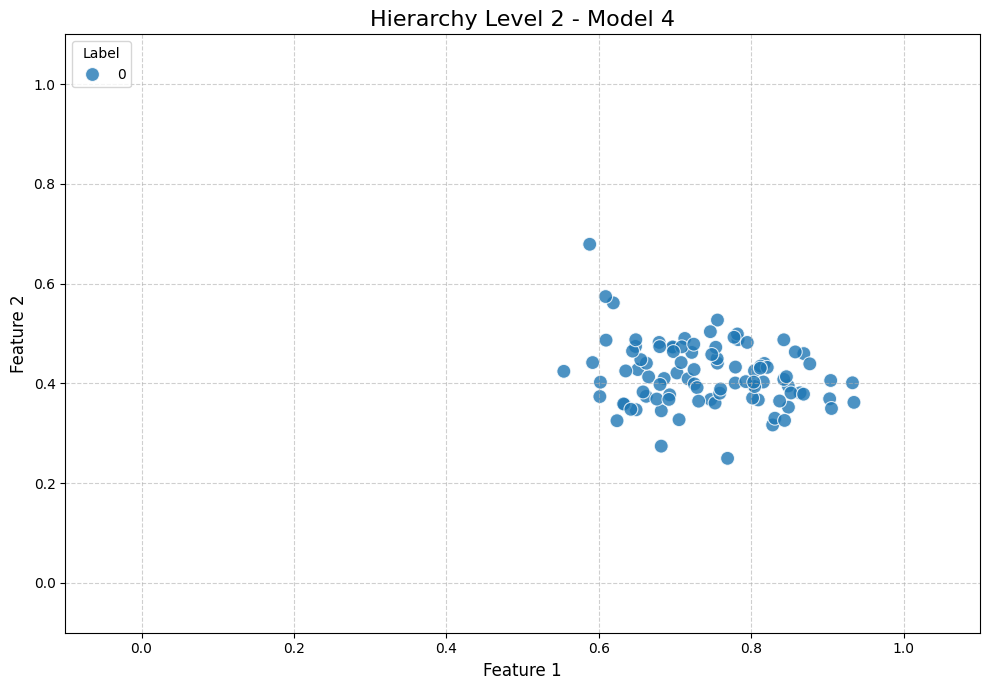

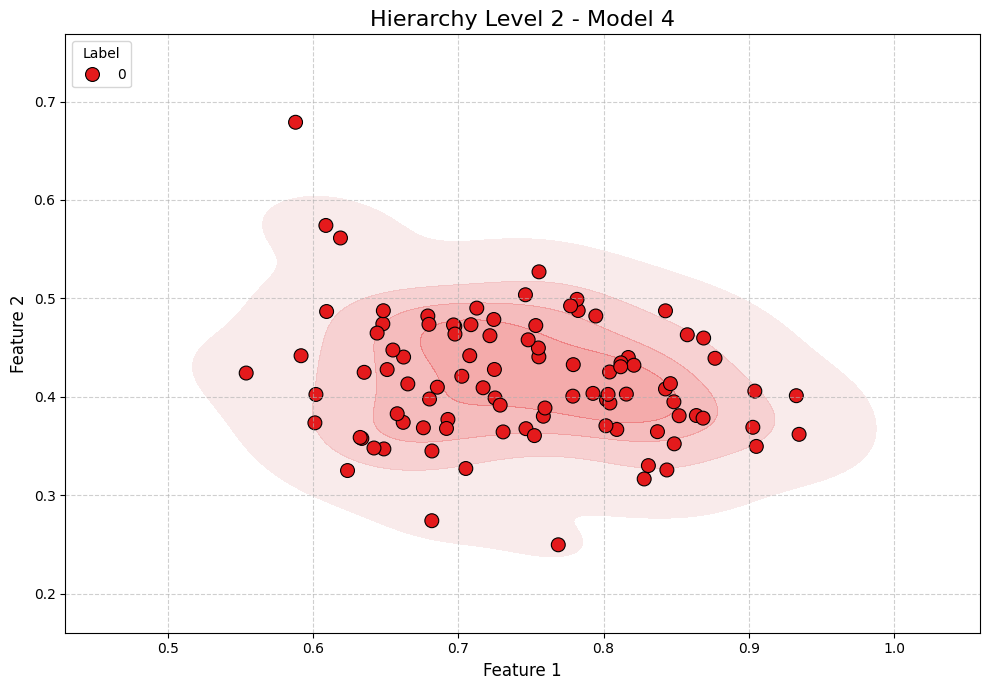

In [36]:
plot_pca(data_Left_side_PCA_c0, 'PCA1', 'PCA2', 'cluster', multi_cluster=False, palette='tab10', 
         graph_title='Hierarchy Level 2 - Model 4', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_2d_scatter_with_hue_background(data_Left_side_PCA_c0, 'PCA1', 'PCA2', 'cluster', 
                                    graph_title='Hierarchy Level 2 - Model 4', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')

### Hierarchy Level 2 - Model 5

In [37]:
# data_Left_side_PCA_c0, data_Left_side_PCA_c1

# Convert features to numpy array
features = data_Left_side_PCA_c1.iloc[:,:2]

# Train Kmean model
clusters = train_kmean_model(N_CLUSTERS, features)
print(clusters)

# Save the model
file_path = os.path.join('..', 'Models', 'kmean_model.pkl')
save_model(clusters, file_path)

# Load the model
clusters = load_model(file_path)

# Predict with the loaded model
y_pred_clusters = predict(clusters, features)
print(y_pred_clusters)

KMeans(n_clusters=2, random_state=5)
Model saved to ..\Models\kmean_model.pkl
Model loaded from ..\Models\kmean_model.pkl
[0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 0
 0 0 1 0 0 0 1 1 1 0 1]


In [38]:
data_Left_side_PCA_c1['y_pred_clusters'] = y_pred_clusters
data_Left_side_PCA_c1.head()

PCA1      PCA2 class_labels  y_pred_clusters  cluster
0  0.945810  0.381036   blue whale                0        1
1  1.000000  0.276532   blue whale                0        1
2  0.836233  0.417344   blue whale                0        1
3  0.781313  0.324194   blue whale                1        1
4  0.775725  0.388813   blue whale                1        1

In [39]:
# Group by Class and Cluster and count the occurrences
grouped = data_Left_side_PCA_c1.groupby(['class_labels', 'y_pred_clusters']).size().unstack(fill_value=0)

# Add a new column to determine the predominant cluster
grouped['finalCluster'] = (grouped[0] < grouped[1]).astype(int)

grouped

y_pred_clusters   0   1  finalCluster
class_labels                         
blue whale       24  24             0

In [40]:
# Save the results to a new CSV file
output_path = os.path.join('..', 'Dataset', 'Left_side_PCA_c1_grouped.csv')  # Specify your output file path here
grouped.to_csv(output_path)
grouped = pd.read_csv(output_path)
# print(grouped.columns, '\n')

# Filter the classes based on the predominant cluster
cluster_0_classes = grouped.loc[grouped['finalCluster'] == 0, 'class_labels'].tolist()
cluster_1_classes = grouped.loc[grouped['finalCluster'] == 1, 'class_labels'].tolist()

# Print the lists
print("Classes in Cluster 0: ", cluster_0_classes, "\n")
print("Classes in Cluster 1: ", cluster_1_classes)

Classes in Cluster 0:  ['blue whale'] 

Classes in Cluster 1:  []


In [41]:
data_Left_side_PCA_c1['cluster'] = data_Left_side_PCA_c1['class_labels'].apply(lambda x: 0 if x in cluster_0_classes else 1)
data_Left_side_PCA_c1

PCA1      PCA2 class_labels  y_pred_clusters  cluster
0   0.945810  0.381036   blue whale                0        0
1   1.000000  0.276532   blue whale                0        0
2   0.836233  0.417344   blue whale                0        0
3   0.781313  0.324194   blue whale                1        0
4   0.775725  0.388813   blue whale                1        0
5   0.817342  0.378095   blue whale                0        0
6   0.790734  0.397261   blue whale                0        0
7   0.897194  0.363740   blue whale                0        0
8   0.858980  0.378828   blue whale                0        0
9   0.831135  0.374492   blue whale                0        0
10  0.708837  0.358476   blue whale                1        0
11  0.778600  0.363863   blue whale                1        0
12  0.782176  0.371102   blue whale                1        0
13  0.805101  0.355109   blue whale                0        0
14  0.673314  0.333674   blue whale                1        0
15  0.765079  0.306658   blue whale                1        0
16  0.812336  0.392894   blue whale                0        0
17  0.663466  0.366469   blue whale                1        0
18  0.857197  0.549651   blue whale                0        0
19  0.727004  0.389690   blue whale                1        0
20  0.680353  0.452559   blue whale                1        0
21  0.880378  0.345995   blue whale                0        0
22  0.810208  0.341934   blue whale                0        0
23  0.768842  0.360732   blue whale                1        0
24  0.707262  0.392874   blue whale                1        0
25  0.745502  0.388888   blue whale                1        0
26  0.794034  0.349517   blue whale                0        0
27  0.635063  0.357432   blue whale                1        0
28  0.741639  0.412144   blue whale                1        0
29  0.747232  0.461708   blue whale                1        0
30  0.828158  0.300896   blue whale                0        0
31  0.755464  0.383935   blue whale                1        0
32  0.823334  0.393447   blue whale                0        0
33  0.940619  0.428003   blue whale                0        0
34  0.691748  0.281493   blue whale                1        0
35  0.765680  0.258116   blue whale                1        0
36  0.803363  0.444009   blue whale                0        0
37  0.841507  0.399442   blue whale                0        0
38  0.855304  0.431727   blue whale                0        0
39  0.720848  0.322504   blue whale                1        0
40  0.781763  0.405042   blue whale                0        0
41  0.864690  0.481868   blue whale                0        0
42  0.803058  0.475195   blue whale                0        0
43  0.683370  0.435716   blue whale                1        0
44  0.693166  0.325682   blue whale                1        0
45  0.759108  0.358469   blue whale                1        0
46  0.777907  0.502779   blue whale                0        0
47  0.668782  0.475932   blue whale                1        0

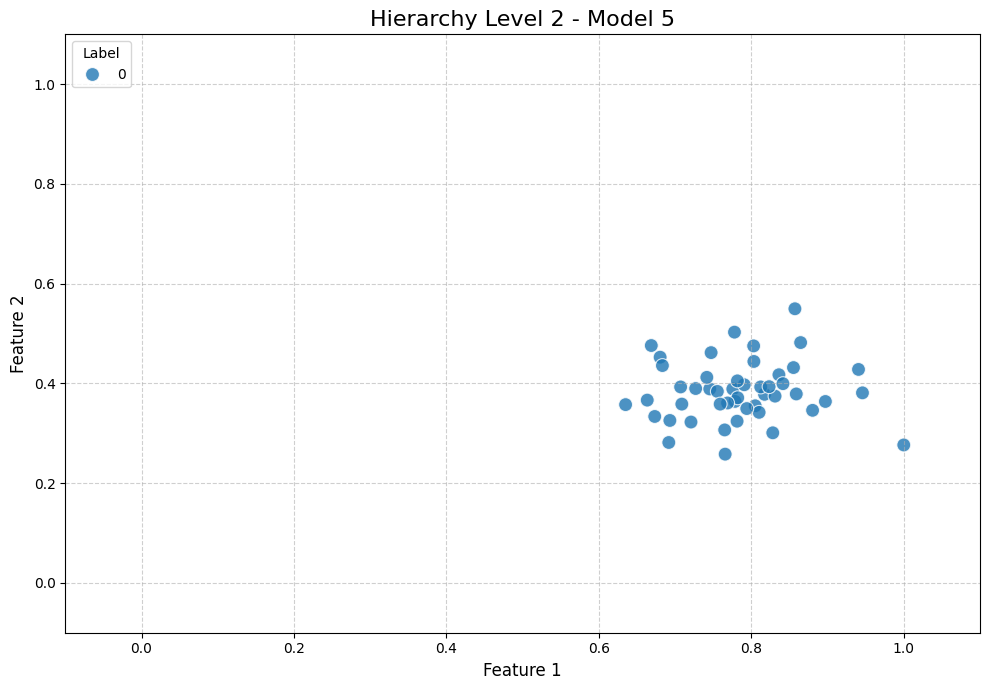

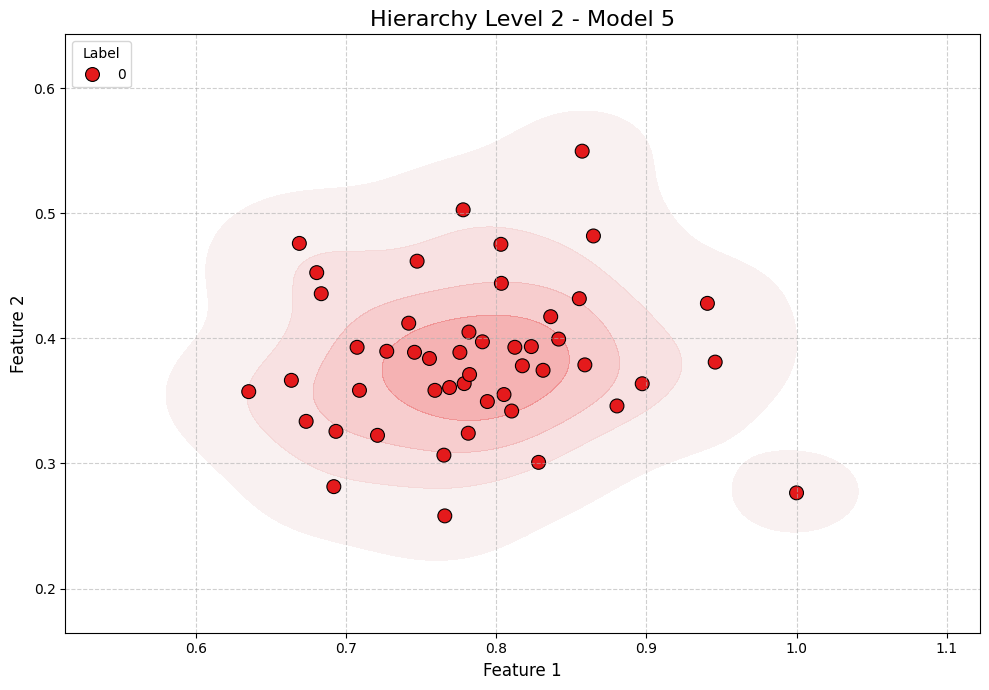

In [42]:
plot_pca(data_Left_side_PCA_c1, 'PCA1', 'PCA2', 'cluster', multi_cluster=False, palette='tab10', 
         graph_title='Hierarchy Level 2 - Model 5', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_2d_scatter_with_hue_background(data_Left_side_PCA_c1, 'PCA1', 'PCA2', 'cluster', 
                                    graph_title='Hierarchy Level 2 - Model 5', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')

## Right branch

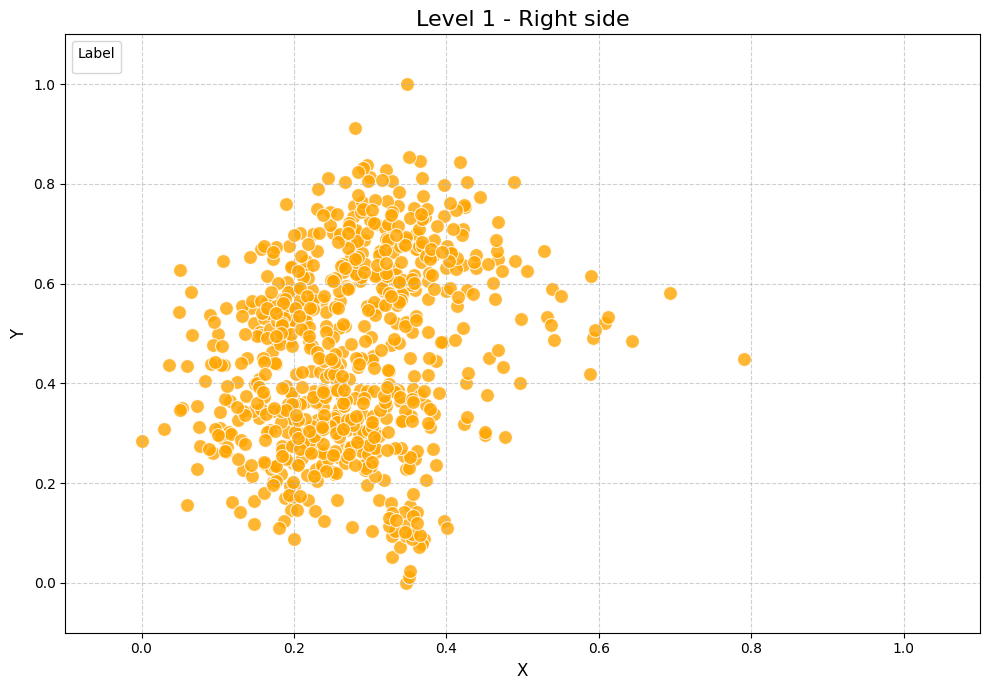

In [43]:
plot_pca(data_PCA_c1, 'PCA1', 'PCA2', 'cluster', graph_color='orange', graph_title='Level 1 - Right side')

In [44]:
# data_PCA_c1

# Convert features to numpy array
features = data_PCA_c1.iloc[:,:2]

# Train Kmean model
clusters = train_kmean_model(N_CLUSTERS, features)
print(clusters)

# Save the model
file_path = os.path.join('..', 'Models', 'kmean_model.pkl')
save_model(clusters, file_path)

# Load the model
clusters = load_model(file_path)

# Predict with the loaded model
y_pred_clusters = predict(clusters, features)
print(y_pred_clusters)

KMeans(n_clusters=2, random_state=5)
Model saved to ..\Models\kmean_model.pkl
Model loaded from ..\Models\kmean_model.pkl
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1
 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 0
 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 

In [45]:
data_PCA_c1['y_pred_clusters'] = y_pred_clusters
data_PCA_c1.head()

PCA1      PCA2 class_labels  y_pred_clusters  cluster
0  0.253617  0.551788         bear                1        1
1  0.323082  0.609280         bear                1        1
2  0.286938  0.605869         bear                1        1
3  0.195660  0.583775         bear                1        1
4  0.463087  0.569048         bear                1        1

In [46]:
# Group by Class and Cluster and count the occurrences
grouped = data_PCA_c1.groupby(['class_labels', 'y_pred_clusters']).size().unstack(fill_value=0)

# Add a new column to determine the predominant cluster
grouped['finalCluster'] = (grouped[0] < grouped[1]).astype(int)

grouped

y_pred_clusters   0   1  finalCluster
class_labels                         
bear              1  47             1
bobcat           47   1             0
cow               0  48             1
gorilla           1  47             1
lion             12  36             1
monkey           27  21             0
mouse            45   3             0
ox                0  48             1
rabbit           48   0             0
rhinoceros        0  47             1
siamese cat      48   0             0
skunk            41   7             0
squirrel         48   0             0
tiger            39   9             0
walrus            1  47             1

In [47]:
# Save the results to a new CSV file
output_path = os.path.join('..', 'Dataset', 'Right_side_PCA_c1_grouped.csv')  # Specify your output file path here
grouped.to_csv(output_path)
grouped = pd.read_csv(output_path)
# print(grouped.columns, '\n')

# Filter the classes based on the predominant cluster
cluster_0_classes = grouped.loc[grouped['finalCluster'] == 0, 'class_labels'].tolist()
cluster_1_classes = grouped.loc[grouped['finalCluster'] == 1, 'class_labels'].tolist()

# Print the lists
print("Classes in Cluster 0: ", cluster_0_classes, "\n")
print("Classes in Cluster 1: ", cluster_1_classes)

Classes in Cluster 0:  ['bobcat', 'monkey', 'mouse', 'rabbit', 'siamese cat', 'skunk', 'squirrel', 'tiger'] 

Classes in Cluster 1:  ['bear', 'cow', 'gorilla', 'lion', 'ox', 'rhinoceros', 'walrus']


In [48]:
data_PCA_c1['cluster'] = data_PCA_c1['class_labels'].apply(lambda x: 0 if x in cluster_0_classes else 1)
data_PCA_c1

PCA1      PCA2 class_labels  y_pred_clusters  cluster
0    0.253617  0.551788         bear                1        1
1    0.323082  0.609280         bear                1        1
2    0.286938  0.605869         bear                1        1
3    0.195660  0.583775         bear                1        1
4    0.463087  0.569048         bear                1        1
..        ...       ...          ...              ...      ...
714  0.409166  0.710531       walrus                1        1
715  0.267354  0.630821       walrus                1        1
716  0.435545  0.644406       walrus                1        1
717  0.643911  0.484640       walrus                1        1
718  0.258262  0.551203       walrus                1        1

[719 rows x 5 columns]

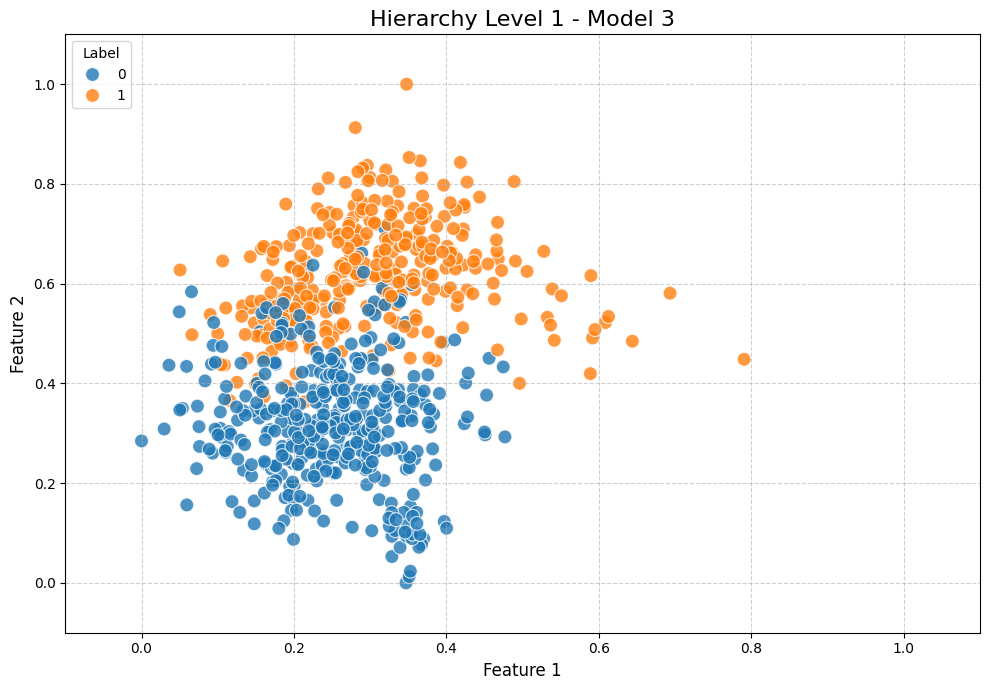

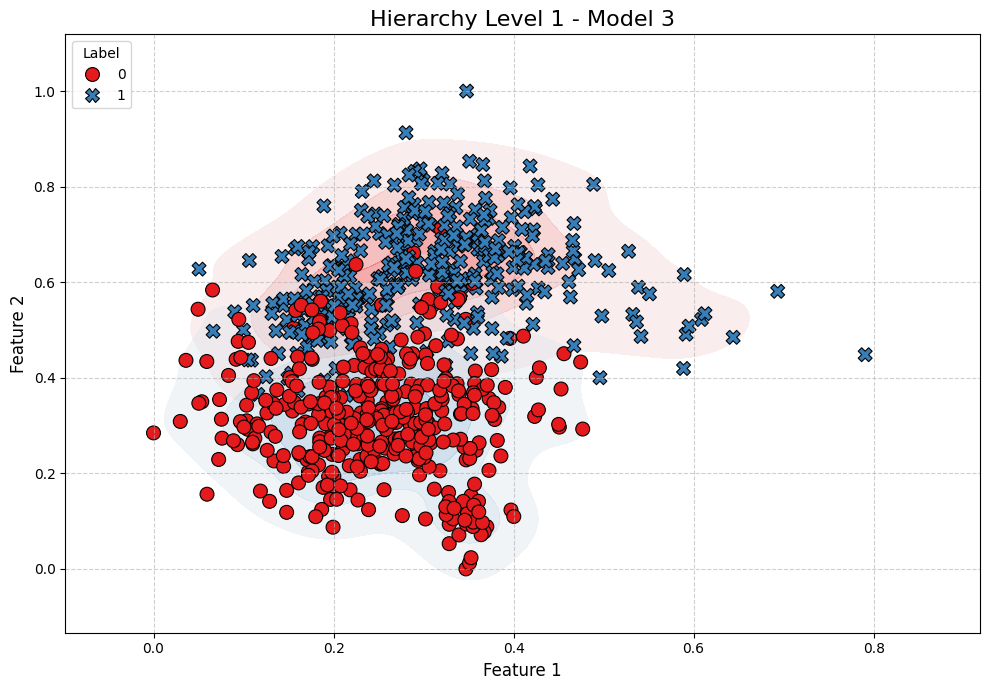

In [49]:
plot_pca(data_PCA_c1, 'PCA1', 'PCA2', 'cluster', multi_cluster=False, palette='tab10', 
         graph_title='Hierarchy Level 1 - Model 3', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_2d_scatter_with_hue_background(data_PCA_c1, 'PCA1', 'PCA2', 'cluster', 
                                    graph_title='Hierarchy Level 1 - Model 3', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')

In [50]:
Right_side_PCA_c0_file_path = os.path.join('..', 'Dataset', 'Right_side_PCA_C0_features.csv')
Right_side_PCA_c1_file_path = os.path.join('..', 'Dataset', 'Right_side_PCA_C1_features.csv')

data_Right_side_PCA_c0 = data_PCA_c1[data_PCA_c1['class_labels'].isin(cluster_0_classes)]
data_Right_side_PCA_c1 = data_PCA_c1[data_PCA_c1['class_labels'].isin(cluster_1_classes)]

data_Right_side_PCA_c0.to_csv(Right_side_PCA_c0_file_path, index=False)
data_Right_side_PCA_c1.to_csv(Right_side_PCA_c1_file_path, index=False)

data_Right_side_PCA_c0 = pd.read_csv(Right_side_PCA_c0_file_path)
data_Right_side_PCA_c1 = pd.read_csv(Right_side_PCA_c1_file_path)

print(f"{data_PCA_c1.shape} \n{data_Right_side_PCA_c0.shape} \n{data_Right_side_PCA_c1.shape}")


(719, 5) 
(384, 5) 
(335, 5)


In [51]:
# data_Right_side_PCA_c0

# Convert features to numpy array
features = data_Right_side_PCA_c0.iloc[:,:2]

# Train Kmean model
clusters = train_kmean_model(N_CLUSTERS, features)
print(clusters)

# Save the model
file_path = os.path.join('..', 'Models', 'kmean_model.pkl')
save_model(clusters, file_path)

# Load the model
clusters = load_model(file_path)

# Predict with the loaded model
y_pred_clusters = predict(clusters, features)
print(y_pred_clusters)

KMeans(n_clusters=2, random_state=5)
Model saved to ..\Models\kmean_model.pkl
Model loaded from ..\Models\kmean_model.pkl
[0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1
 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1
 1 0 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1
 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1
 0 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 1
 1 1 1 1 0 0 1 1 1 1 1 1 1 1]


In [52]:
data_Right_side_PCA_c0['y_pred_clusters'] = y_pred_clusters
data_Right_side_PCA_c0.head()

PCA1      PCA2 class_labels  y_pred_clusters  cluster
0  0.076148  0.273552       bobcat                0        0
1  0.072346  0.229034       bobcat                0        0
2  0.103547  0.309870       bobcat                0        0
3  0.172022  0.202614       bobcat                0        0
4  0.136926  0.374555       bobcat                1        0

In [53]:
# Group by Class and Cluster and count the occurrences
grouped = data_Right_side_PCA_c0.groupby(['class_labels', 'y_pred_clusters']).size().unstack(fill_value=0)

# Add a new column to determine the predominant cluster
grouped['finalCluster'] = (grouped[0] < grouped[1]).astype(int)

grouped

y_pred_clusters   0   1  finalCluster
class_labels                         
bobcat           40   8             0
monkey            1  47             1
mouse            28  20             0
rabbit           36  12             0
siamese cat      45   3             0
skunk            20  28             1
squirrel         21  27             1
tiger            13  35             1

In [54]:
# Save the results to a new CSV file
output_path = os.path.join('..', 'Dataset', 'Right_side_PCA_c0_grouped.csv')  # Specify your output file path here
grouped.to_csv(output_path)
grouped = pd.read_csv(output_path)
# print(grouped.columns, '\n')

# Filter the classes based on the predominant cluster
cluster_0_classes = grouped.loc[grouped['finalCluster'] == 0, 'class_labels'].tolist()
cluster_1_classes = grouped.loc[grouped['finalCluster'] == 1, 'class_labels'].tolist()

# Print the lists
print("Classes in Cluster 0: ", cluster_0_classes, "\n")
print("Classes in Cluster 1: ", cluster_1_classes)

Classes in Cluster 0:  ['bobcat', 'mouse', 'rabbit', 'siamese cat'] 

Classes in Cluster 1:  ['monkey', 'skunk', 'squirrel', 'tiger']


In [55]:
data_Right_side_PCA_c0['cluster'] = data_Right_side_PCA_c0['class_labels'].apply(lambda x: 0 if x in cluster_0_classes else 1)
data_Right_side_PCA_c0

PCA1      PCA2 class_labels  y_pred_clusters  cluster
0    0.076148  0.273552       bobcat                0        0
1    0.072346  0.229034       bobcat                0        0
2    0.103547  0.309870       bobcat                0        0
3    0.172022  0.202614       bobcat                0        0
4    0.136926  0.374555       bobcat                1        0
..        ...       ...          ...              ...      ...
379  0.065578  0.583766        tiger                1        1
380  0.183932  0.390580        tiger                1        1
381  0.176049  0.541965        tiger                1        1
382  0.174344  0.349958        tiger                1        1
383  0.253318  0.552266        tiger                1        1

[384 rows x 5 columns]

## Issue : As I told you - if we don't preprocessing part then this will happend

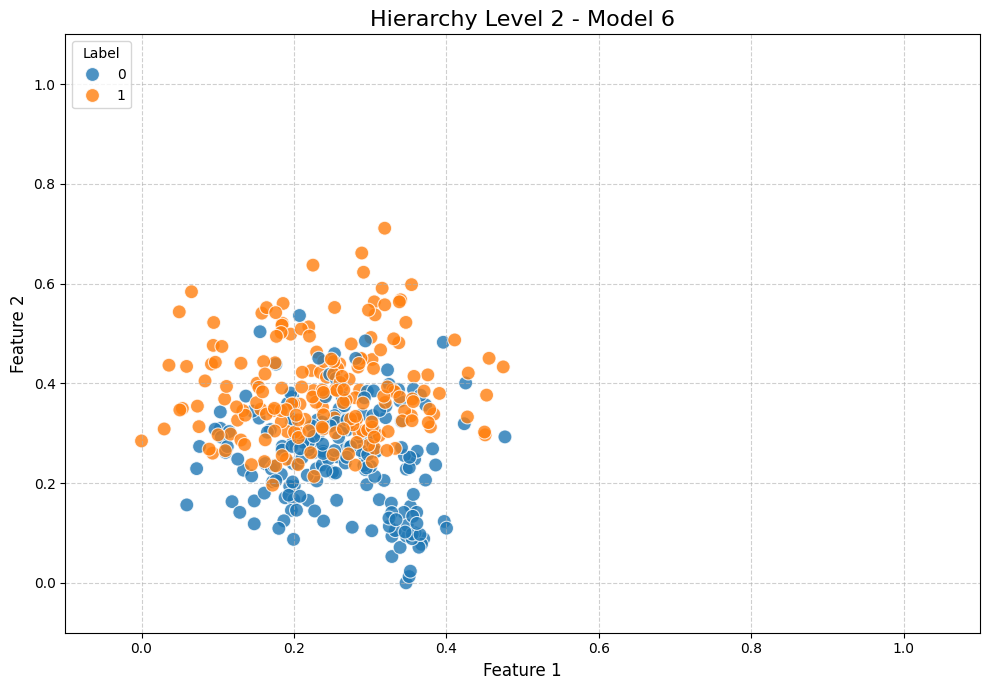

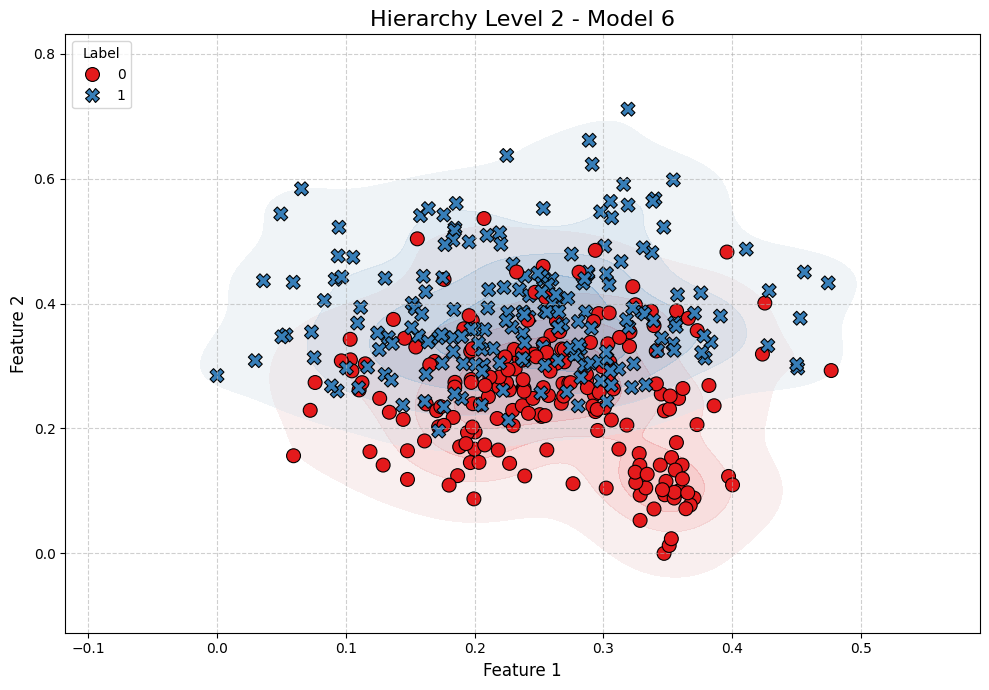

In [56]:
plot_pca(data_Right_side_PCA_c0, 'PCA1', 'PCA2', 'cluster', multi_cluster=False, palette='tab10', 
         graph_title='Hierarchy Level 2 - Model 6', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_2d_scatter_with_hue_background(data_Right_side_PCA_c0, 'PCA1', 'PCA2', 'cluster', 
                                    graph_title='Hierarchy Level 2 - Model 6', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')

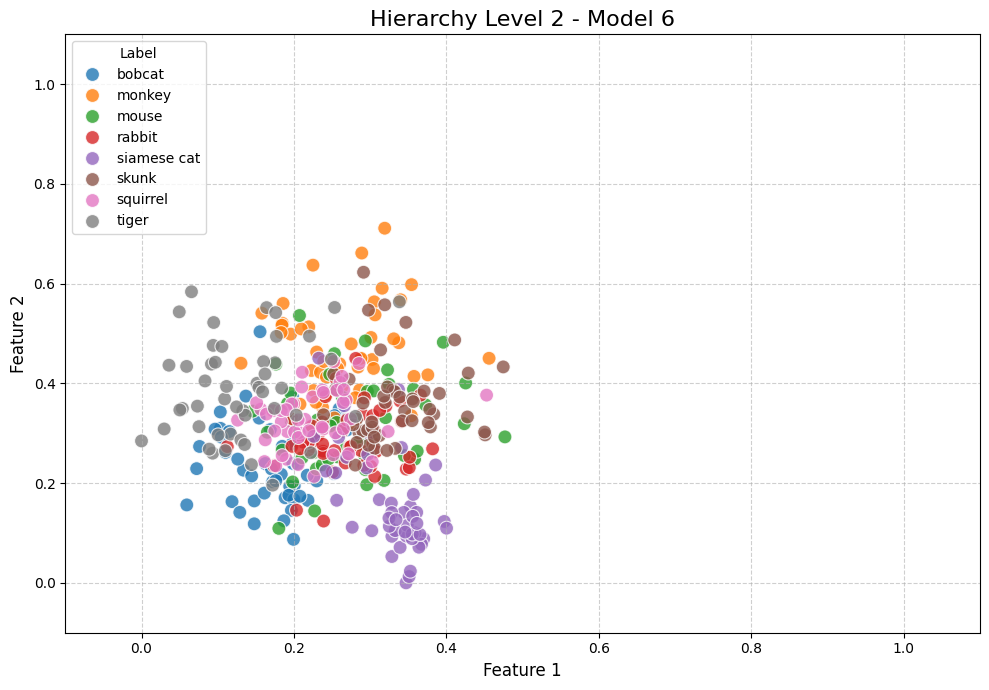

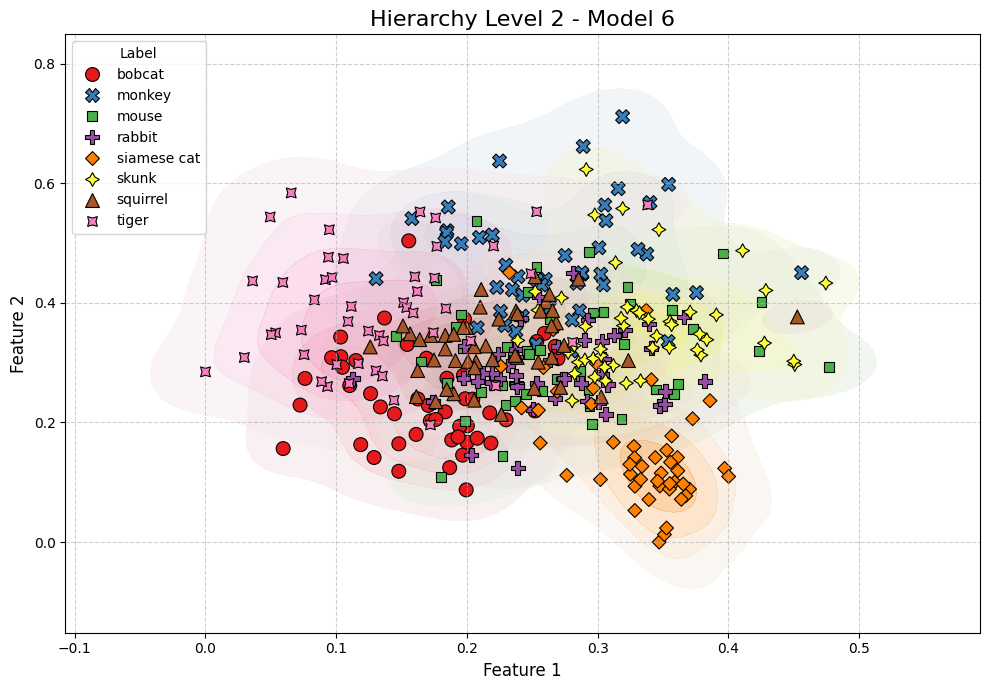

In [57]:
plot_pca(data_Right_side_PCA_c0, 'PCA1', 'PCA2', 'class_labels', multi_cluster=False, palette='tab10', 
         graph_title='Hierarchy Level 2 - Model 6', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_2d_scatter_with_hue_background(data_Right_side_PCA_c0, 'PCA1', 'PCA2', 'class_labels', 
                                    graph_title='Hierarchy Level 2 - Model 6', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')

## Jugad

In [58]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder and create new column 'cluster1'
data_Right_side_PCA_c0['cluster1'] = label_encoder.fit_transform(data_Right_side_PCA_c0['class_labels'])

# Display the DataFrame
data_Right_side_PCA_c0


PCA1      PCA2 class_labels  y_pred_clusters  cluster  cluster1
0    0.076148  0.273552       bobcat                0        0         0
1    0.072346  0.229034       bobcat                0        0         0
2    0.103547  0.309870       bobcat                0        0         0
3    0.172022  0.202614       bobcat                0        0         0
4    0.136926  0.374555       bobcat                1        0         0
..        ...       ...          ...              ...      ...       ...
379  0.065578  0.583766        tiger                1        1         7
380  0.183932  0.390580        tiger                1        1         7
381  0.176049  0.541965        tiger                1        1         7
382  0.174344  0.349958        tiger                1        1         7
383  0.253318  0.552266        tiger                1        1         7

[384 rows x 6 columns]

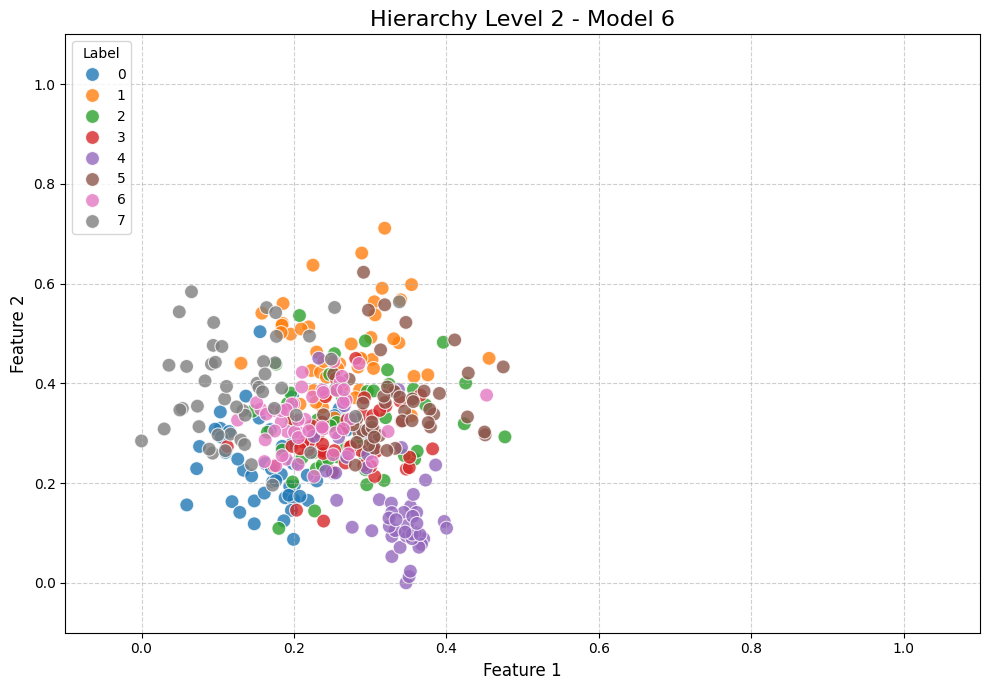

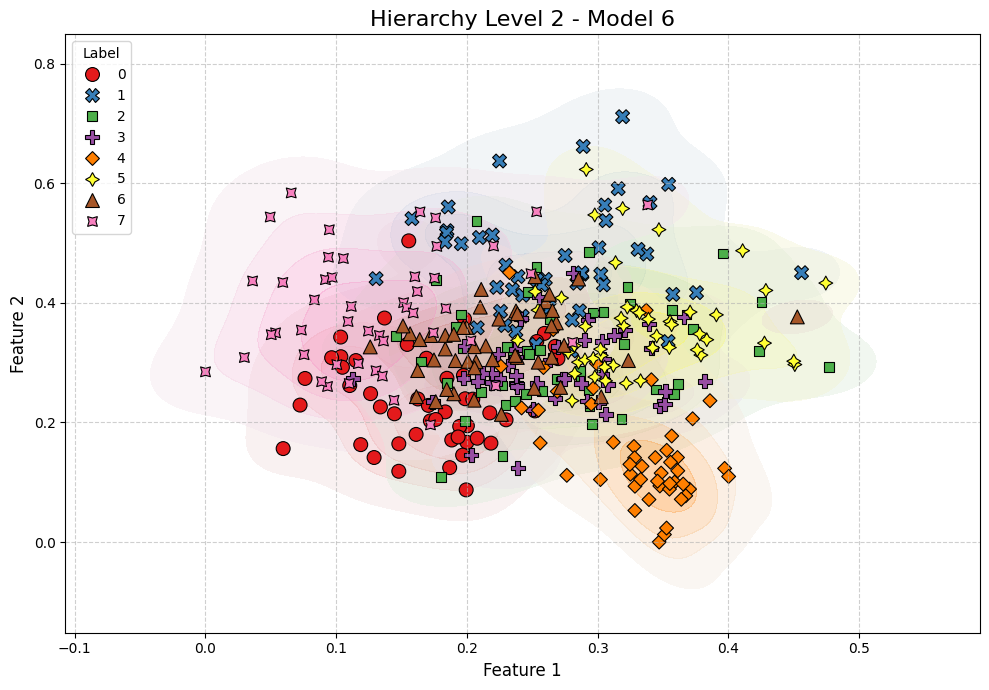

In [59]:
plot_pca(data_Right_side_PCA_c0, 'PCA1', 'PCA2', 'cluster1', multi_cluster=False, palette='tab10', 
         graph_title='Hierarchy Level 2 - Model 6', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_2d_scatter_with_hue_background(data_Right_side_PCA_c0, 'PCA1', 'PCA2', 'cluster1', 
                                    graph_title='Hierarchy Level 2 - Model 6', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')

In [60]:
# data_Right_side_PCA_c1

# Convert features to numpy array
features = data_Right_side_PCA_c1.iloc[:,:2]

# Train Kmean model
clusters = train_kmean_model(N_CLUSTERS, features)
print(clusters)

# Save the model
file_path = os.path.join('..', 'Models', 'kmean_model.pkl')
save_model(clusters, file_path)

# Load the model
clusters = load_model(file_path)

# Predict with the loaded model
y_pred_clusters = predict(clusters, features)
print(y_pred_clusters)

KMeans(n_clusters=2, random_state=5)
Model saved to ..\Models\kmean_model.pkl
Model loaded from ..\Models\kmean_model.pkl
[1 0 1 1 0 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 0 1 0
 0 0 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 0 1]


In [61]:
data_Right_side_PCA_c1['y_pred_clusters'] = y_pred_clusters
data_Right_side_PCA_c1.head()

PCA1      PCA2 class_labels  y_pred_clusters  cluster
0  0.253617  0.551788         bear                1        1
1  0.323082  0.609280         bear                0        1
2  0.286938  0.605869         bear                1        1
3  0.195660  0.583775         bear                1        1
4  0.463087  0.569048         bear                0        1

In [62]:
# Group by Class and Cluster and count the occurrences
grouped = data_Right_side_PCA_c1.groupby(['class_labels', 'y_pred_clusters']).size().unstack(fill_value=0)

# Add a new column to determine the predominant cluster
grouped['finalCluster'] = (grouped[0] < grouped[1]).astype(int)

grouped

y_pred_clusters   0   1  finalCluster
class_labels                         
bear             21  27             1
cow              41   7             0
gorilla           1  47             1
lion              1  47             1
ox               45   3             0
rhinoceros       42   5             0
walrus           43   5             0

In [63]:
# Save the results to a new CSV file
output_path = os.path.join('..', 'Dataset', 'Right_side_PCA_c1_grouped.csv')  # Specify your output file path here
grouped.to_csv(output_path)
grouped = pd.read_csv(output_path)
# print(grouped.columns, '\n')

# Filter the classes based on the predominant cluster
cluster_0_classes = grouped.loc[grouped['finalCluster'] == 0, 'class_labels'].tolist()
cluster_1_classes = grouped.loc[grouped['finalCluster'] == 1, 'class_labels'].tolist()

# Print the lists
print("Classes in Cluster 0: ", cluster_0_classes, "\n")
print("Classes in Cluster 1: ", cluster_1_classes)

Classes in Cluster 0:  ['cow', 'ox', 'rhinoceros', 'walrus'] 

Classes in Cluster 1:  ['bear', 'gorilla', 'lion']


In [64]:
data_Right_side_PCA_c1['cluster'] = data_Right_side_PCA_c1['class_labels'].apply(lambda x: 0 if x in cluster_0_classes else 1)
data_Right_side_PCA_c1

PCA1      PCA2 class_labels  y_pred_clusters  cluster
0    0.253617  0.551788         bear                1        1
1    0.323082  0.609280         bear                0        1
2    0.286938  0.605869         bear                1        1
3    0.195660  0.583775         bear                1        1
4    0.463087  0.569048         bear                0        1
..        ...       ...          ...              ...      ...
330  0.409166  0.710531       walrus                0        0
331  0.267354  0.630821       walrus                1        0
332  0.435545  0.644406       walrus                0        0
333  0.643911  0.484640       walrus                0        0
334  0.258262  0.551203       walrus                1        0

[335 rows x 5 columns]

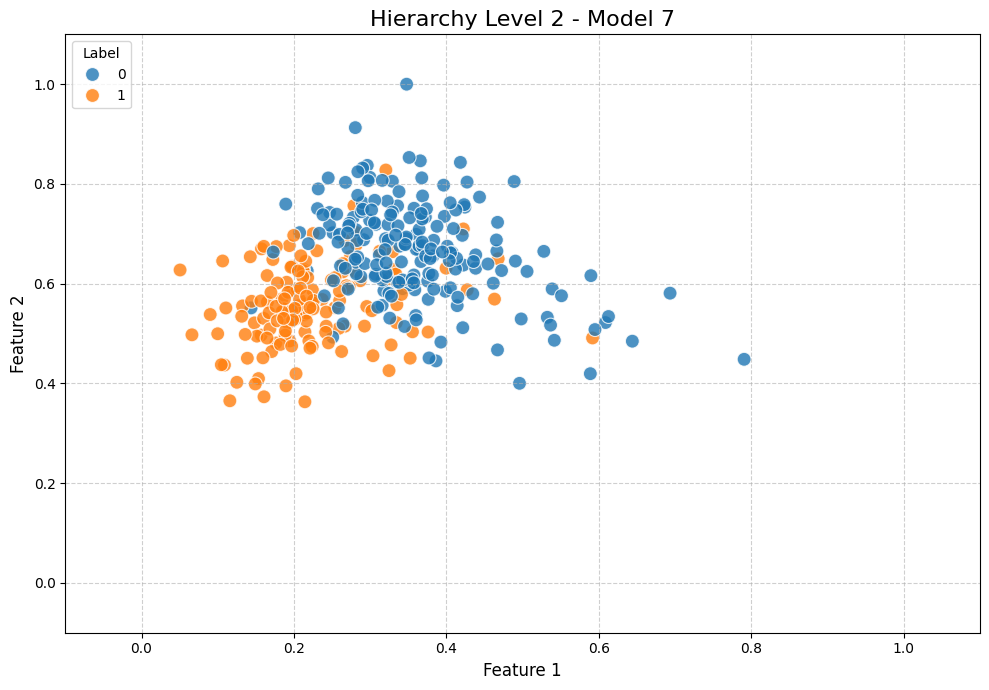

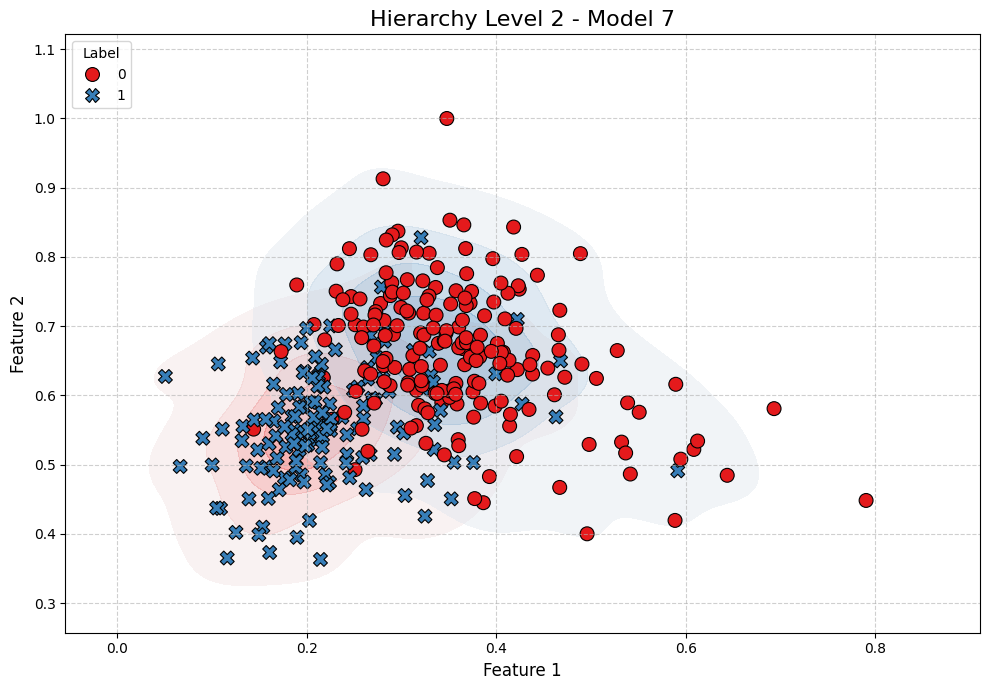

In [65]:
plot_pca(data_Right_side_PCA_c1, 'PCA1', 'PCA2', 'cluster', multi_cluster=False, palette='tab10', 
         graph_title='Hierarchy Level 2 - Model 7', 
         graph_xlabel='Feature 1', graph_ylabel='Feature 2')

plot_2d_scatter_with_hue_background(data_Right_side_PCA_c1, 'PCA1', 'PCA2', 'cluster', 
                                    graph_title='Hierarchy Level 2 - Model 7', 
                                    graph_xlabel='Feature 1', graph_ylabel='Feature 2')